<a href="https://colab.research.google.com/github/gus-s-ramos/AlgoritmoAtividadeFinal/blob/main/colabs/xg_boost_with_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# XGBoost —>  O que é

**XGBoost (eXtreme Gradient Boosting)** é uma implementação altamente otimizada do **gradient boosting** sobre **árvores de decisão**. Ele constrói o modelo de forma **aditiva**: começa simples e, a cada iteração (“árvore fraca”), corrige os **erros residuais** das iterações anteriores. O diferencial do XGBoost é combinar:

* **Regularização explícita** (controle de complexidade da árvore),
* **Segundo-ordem do gradiente** (usa gradiente e **hessiano**),
* **Amostragens** de linhas e colunas,
* **Treinamento paralelo**, suporte a **GPU** e dados **esparsos**,
* **Parada antecipada** e recursos extras (monotonicidade, tratamento de categorias, etc.).

---

## Função objetivo (visão matemática)

O modelo final é uma soma de árvores:

$$
\hat{y}_i = \sum_{t=1}^{T} f_t(x_i), \quad f_t \in \mathcal{F} \;(\text{árvores})
$$

A cada iteração $t$, minimiza-se:

$$
\mathcal{L}^{(t)} \approx \sum_{i=1}^{n} \left[ g_i w(x_i) + \tfrac{1}{2} h_i w(x_i)^2 \right] + \Omega(f_t)
$$

onde $g_i$ e $h_i$ são **gradiente** e **hessiano** da perda em relação à predição anterior; $w(x_i)$ é o incremento previsto pela nova árvore; e

$$
\Omega(f) = \gamma \cdot T_{\text{nós}} + \tfrac{\lambda}{2}\sum_{j} w_j^2
$$

penaliza número de folhas ($\gamma$) e pesos das folhas ($\lambda$).

Para cada **folha** com soma de gradientes $G$ e hessianos $H$, o peso ótimo é:

$$
w^* = -\frac{G}{H + \lambda}
$$

e o **ganho** de um **split** (quebra) é:

$$
\text{Gain} = \tfrac{1}{2} \left(\frac{G_L^2}{H_L+\lambda} + \frac{G_R^2}{H_R+\lambda} - \frac{G^2}{H+\lambda}\right) - \gamma
$$

(Se o ganho $\le 0$, não vale a pena dividir.)

---

## Como ele constrói as árvores

1. **Calcula** $g_i$ e $h_i$ (1ª e 2ª derivadas da perda) em todos os exemplos.
2. **Procura quebras** que maximizem o **ganho** (acima). Pode usar método **hist** (mais rápido e padrão atual) ou **gpu\_hist**.
3. **Aplica regularização** para evitar overfitting (parâmetros $\gamma, \lambda, \alpha$).
4. **Adiciona** a árvore ao conjunto com um **learning rate** ($\eta$, “shrinkage”).
5. **Repete** até atingir $n\_estimators$ ou **early stopping**.

---

## Por que ele é rápido/robusto

* **Histograma/quantis** para procurar splits (menor custo).
* **Suporte a esparsidade** (faltantes e zeros tratados com caminhos padrão na árvore).
* **Subamostragem** de linhas ( `subsample` ) e colunas ( `colsample_bytree/by_level/by_node` ).
* **Paralelização** e **GPU** (`tree_method='gpu_hist'`).
* **Regularização** forte na estrutura da árvore.

---

## Hiperparâmetros (o que mais importa)

* **`n_estimators`**: número de árvores. Quanto maior, melhor, **até** overfitting; combine com `learning_rate`.
* **`learning_rate` (η)**: passo de cada árvore. Valores **menores (0.01–0.1)** costumam generalizar melhor, mas exigem mais árvores.
* **`max_depth` / `max_leaves`**: controla complexidade. Árvores mais rasas/leaves limitadas ajudam a generalizar.
* **`min_child_weight`**: mínimo de hessiano por folha; aumenta → modelo mais conservador.
* **`gamma`**: ganho mínimo para dividir; maior → menos splits.
* **`subsample`, `colsample_bytree`**: 0.6–0.9 são bons pontos de partida.
* **`reg_lambda`, `reg_alpha`**: L2 e L1 nos pesos; reduzem overfitting.
* **`tree_method`**: `hist` (padrão rápido), `gpu_hist` (se GPU).
* **Classificação desbalanceada**: **`scale_pos_weight = n_neg/n_pos`** ajuda bastante.

> Dica de prática: fixe `n_estimators` alto (p.ex. 2000) e use **`early_stopping_rounds`** com validação para “parar” no ponto ótimo.

---

## Quando usar (e quando evitar)

* **Usar**: tabulares pequenos a médios, com mistura de numéricas/categóricas, dados esparsos, relações não lineares, competição de Kaggle.
* **Evitar/avaliar**: dados massivos com milhões de linhas + muitas categorias de alta cardinalidade (às vezes **CatBoost** lida melhor com categorias), ou quando você pode explorar representações em sequência/imagem (redes neurais).

### Catboost: [Referência](https://catboost.ai/docs/en/concepts/educational-materials-papers)

---

## Boas práticas rápidas

* Separe **validação** e use **early stopping**.
* Ajuste primeiro **taxa de aprendizado** e **n\_estimators**, depois **profundidade** e **regularização**.
* Para **classes desbalanceadas**, ajuste `scale_pos_weight` E avalie por **AUC/PR**, **F1**, não só acurácia.
* Avalie **importâncias** com **permutation** ou **SHAP** (as importâncias “gain”/“weight” podem enganar).
* Trate categorias: versões recentes suportam **categorical nativo** (ou use one-hot/target encoding); valide o que funciona melhor no seu dado.

---

## Exemplos de código

### (A) API estilo scikit-learn — classificação binária

```python
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

model = XGBClassifier(
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.0,
    min_child_weight=1.0,
    objective="binary:logistic",
    tree_method="hist",           # use "gpu_hist" se tiver GPU
    eval_metric="auc",
    n_jobs=-1
)

model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    verbose=False,
    early_stopping_rounds=100
)

pred_proba = model.predict_proba(X_valid)[:, 1]
print("AUC:", roc_auc_score(y_valid, pred_proba))
```

**Desbalanceamento:**

```python
# Regra prática: n_neg / n_pos
from collections import Counter
cnt = Counter(y_train)
scale = cnt[0] / cnt[1]
model.set_params(scale_pos_weight=scale)
```

### (B) Regressão com DMatrix (API “baixa”)

```python
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

params = {
    "objective": "reg:squarederror",
    "eta": 0.05,
    "max_depth": 8,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "lambda": 1.0,
    "alpha": 0.0,
    "tree_method": "hist",
    "eval_metric": "rmse"
}

watchlist = [(dtrain, "train"), (dvalid, "valid")]
bst = xgb.train(params, dtrain, num_boost_round=5000, evals=watchlist, early_stopping_rounds=200)
```

### (C) Categorias nativas (pandas `category`)

```python
import pandas as pd
X_cat = X.copy()
for col in cat_cols:
    X_cat[col] = X_cat[col].astype("category")

model = XGBClassifier(
    tree_method="hist",
    enable_categorical=True,   # suporta divisão por categoria sem one-hot
    # demais parâmetros...
)
model.fit(X_cat, y)
```

### (D) Restrições monotônicas (útil em risco/crédito)

```python
# Ex.: y deve crescer com feature1 e decrescer com feature2
# ordem das restrições segue a ordem das colunas em X
model = XGBRegressor(
    monotone_constraints="(1,-1,0,0)",  # 1: crescente, -1: decrescente, 0: livre
    tree_method="hist",
    # demais parâmetros...
)
```

### (E) Importância & SHAP (interpretação)

```python
# Importância padrão
import matplotlib.pyplot as plt
xgb.plot_importance(model, max_num_features=15)
plt.show()

# SHAP (melhor para explicabilidade global/local)
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_valid)
shap.summary_plot(shap_values, X_valid)  # requer ambiente gráfico
```

---

## Hiperparâmetros — valores de partida (heurística)

* Classificação:

  * `learning_rate=0.05`, `n_estimators=2000`, `early_stopping_rounds=100–300`
  * `max_depth=4–8` (ou usar `max_leaves` \~ 31–255)
  * `subsample=0.8`, `colsample_bytree=0.8`
  * `min_child_weight=1–5`, `gamma=0–5`
  * `reg_lambda=1–5`, `reg_alpha=0–1`
* Regressão:

  * Parecido; ajuste `eval_metric` para `rmse`/`mae`.

---

## Erros comuns (e como evitar)

* **Acurácia em dado desbalanceado** → use **AUC-PR**, **F1**, **Recall**; ajuste `scale_pos_weight`.
* **Overfitting com `max_depth` alto** → aumente regularização e use early stopping.
* **Parar cedo demais** → `early_stopping_rounds` muito baixo; aumente e valide.
* **Importâncias ingênuas** → prefira **Permutation** / **SHAP**.
* **Leakage** (ex.: variáveis pós-evento) → reavalie features e validação temporal.

---

## Resumo

* XGBoost = **gradient boosting** + **regularização forte** + **segundo-ordem** + **engenharia de velocidade**.
* Brilha em **dados tabulares** e entrega **ótima performance** com bons defaults.
* Foque em: **learning rate + early stopping**, **profundidade/folhas**, **regularização**, **subamostragens**, e métricas corretas.



# Pseudocode

```python
Entrada:
    - Dados de treino: X = {x₁,...,xₙ}, rótulos y = {y₁,...,yₙ}
    - Função de perda L(y, ŷ)
    - Número de árvores T
    - Taxa de aprendizado η
    - Parâmetros de regularização (λ, γ, etc.)

Inicialização:
    - Definir predição inicial ŷᵢ⁽⁰⁾ (ex: média de y no caso de regressão log odds no caso de classificação)

Para t = 1 até T:   # loop de boosting
    1. Calcular gradiente e hessiano para cada exemplo i:
           gᵢ = ∂L(yᵢ, ŷᵢ⁽ᵗ⁻¹⁾) / ∂ŷᵢ
           hᵢ = ∂²L(yᵢ, ŷᵢ⁽ᵗ⁻¹⁾) / ∂ŷᵢ²

    2. Construir uma árvore de decisão fₜ(x):
        - Começar com um nó raiz contendo todos os exemplos
        - Enquanto possível:
            Para cada variável de entrada e ponto de corte candidato:
                - Calcular somas G, H de gradientes e hessianos nos grupos esquerdo (L) e direito (R) (VEJA DETALHES ABAIXO)
                - Calcular ganho:
                      Gain = ½ [ G_L² / (H_L + λ) + G_R² / (H_R + λ) - G² / (H + λ) ] - γ
                - Escolher split com maior ganho positivo
            Se ganho ≤ 0: não dividir mais o nó

        - Para cada folha j da árvore:
            - Calcular peso ótimo:
                  wⱼ* = - Gⱼ / (Hⱼ + λ)

    3. Atualizar predições:
           ŷᵢ⁽ᵗ⁾ = ŷᵢ⁽ᵗ⁻¹⁾ + η ⋅ fₜ(xᵢ)

Saída:
    - Modelo final: ŷ(x) = Σₜ η ⋅ fₜ(x)


```


Referência: [O que é uma matrix hessiana](https://www.datacamp.com/pt/tutorial/hessian-matrix)

#Contexto

Quando estamos em um nó de uma árvore em construção, temos um **conjunto de exemplos** $S$ que caíram nesse nó.
Para decidir se devemos **dividir** o nó em dois grupos (esquerda L e direita R), o XGBoost olha para o quanto essa divisão **reduz a perda** esperada.

A perda aproximada é baseada em **gradientes** e **hessianos** de cada exemplo em relação à predição atual.

---

# Gradiente e Hessiano

Para cada exemplo $i$ no nó:

* **Gradiente**

$$
g_i = \frac{\partial L(y_i, \hat{y}_i)}{\partial \hat{y}_i}
$$

Indica a direção do erro (positivo/negativo).

* **Hessiano**

$$
h_i = \frac{\partial^2 L(y_i, \hat{y}_i)}{\partial \hat{y}_i^2}
$$

Indica a “curvatura” da perda (quanto confiar no gradiente).

---

# Somas G e H

Agora, dentro de um nó:

* Para todos os exemplos $i \in S$:

$$
G = \sum_{i \in S} g_i, \quad H = \sum_{i \in S} h_i
$$

* Se fazemos uma divisão (split), separamos os exemplos em **lado esquerdo (L)** e **lado direito (R)**:

$$
G_L = \sum_{i \in L} g_i, \quad H_L = \sum_{i \in L} h_i
$$

$$
G_R = \sum_{i \in R} g_i, \quad H_R = \sum_{i \in R} h_i
$$

E claro:

$$
G = G_L + G_R, \quad H = H_L + H_R
$$

---

# Como isso é usado

O XGBoost calcula o **ganho da divisão** assim:

$$
\text{Gain} = \tfrac{1}{2} \left( \frac{G_L^2}{H_L + \lambda} + \frac{G_R^2}{H_R + \lambda} - \frac{G^2}{H + \lambda} \right) - \gamma
$$

* **Primeiro termo:** qualidade de deixar só os exemplos à esquerda.
* **Segundo termo:** qualidade de deixar só os exemplos à direita.
* **Terceiro termo:** qualidade do nó antes de dividir (baseline).
* Subtraímos $\gamma$ = penalidade por criar um novo split.

Se o **ganho > 0**, a divisão ajuda → o split é aceito.
Se **ganho ≤ 0**, o XGBoost não divide.

---

# Intuição

* **$G$** mede “quanto erro acumulado” tem naquele grupo (via gradientes).
* **$H$** mede “quanta informação de curvatura” temos (ajuda a estabilizar).
* Dividir em L e R significa redistribuir o erro em duas folhas, cada uma com seu peso ótimo.
* O ganho mede se essa redistribuição **reduz a perda global** mais do que custa criar um novo nó.




XGBoost, Decision Tree e Random Forest são todos **métodos baseados em árvores de decisão**, mas com filosofias bem diferentes.

Abaixo a comparação em **estrutura**, **como aprendem**, **vantagens** e **desvantagens**.


# **Decision Tree (árvore única)**

* **Como funciona:**

  * Divide o espaço de atributos em regiões, escolhendo splits que maximizam algum critério (ex.: Gini, entropia, MSE).
  * Cada folha dá uma predição (classe majoritária ou média da variável alvo).
* **Pontos fortes:**

  * Simples de entender e visualizar.
  * Não precisa de muita preparação dos dados (normalização, linearidade, etc.).
  * Interpretação intuitiva.
* **Pontos fracos:**

  * Muito instável: pequenas mudanças nos dados podem gerar árvores muito diferentes.
  * Alta tendência a **overfitting** (se não for podada ou limitada em profundidade).
  * Pouco competitiva sozinha em datasets complexos.

---

# **Random Forest (ensemble bagging de árvores)**

* **Como funciona:**

  * Constrói **muitas árvores de decisão independentes** em subconjuntos **bootstrap** dos dados (bagging).
  * Em cada split da árvore, considera **apenas um subconjunto aleatório de variáveis**.
  * Predição final: média (regressão) ou votação (classificação).
* **Pontos fortes:**

  * Reduz **variância** em relação a uma única árvore → mais estável.
  * Lida bem com dados de alta dimensionalidade.
  * Funciona bem em muitos problemas “out of the box”.
* **Pontos fracos:**

  * Cada árvore é profunda → menos interpretável.
  * Modelo pesado (centenas/milhares de árvores).
  * Correlações entre árvores ainda limitam a melhora de performance.
  * Não tem mecanismo explícito de correção de viés.

---

# **XGBoost (gradient boosting de árvores)**

* **Como funciona:**

  * Constrói árvores **sequencialmente** (não em paralelo).
  * Cada nova árvore tenta corrigir os **erros residuais** das anteriores, usando **gradiente + hessiano** da função de perda.
  * Usa **regularização forte** ($\lambda, \gamma, \alpha$) para evitar overfitting.
  * Implementa otimizações (histogramas, sparsity-aware, GPU, etc.).
* **Pontos fortes:**

  * Altíssima performance em dados tabulares.
  * Melhor controle de overfitting do que RF.
  * Suporta customização de função de perda (classificação, regressão, ranking).
  * Tem recursos avançados (tratamento de categorias, restrições monotônicas, early stopping).
* **Pontos fracos:**

  * Mais difícil de **tunar** (hiperparâmetros sensíveis).
  * Mais lento de treinar que uma árvore ou até um RF simples (mas ainda muito otimizado).
  * Menos interpretável diretamente (precisa de SHAP, feature importance, etc.).

---

# Comparação direta

| Característica       | Decision Tree       | Random Forest               | XGBoost (Boosting)                     |
| -------------------- | ------------------- | --------------------------- | -------------------------------------- |
| Estrutura            | Uma árvore          | Muitas árvores, em paralelo | Muitas árvores, em sequência           |
| Combate overfitting  | Podas/profundidade  | Bagging + voto              | Regularização + boosting               |
| Variância            | Alta                | Baixa                       | Média-baixa (regularizada)             |
| Viés                 | Baixo (se profunda) | Médio (média de árvores)    | Muito baixo (corrige iterativamente)   |
| Velocidade de treino | Muito rápido        | Médio (paralelizável)       | Mais lento (sequencial, mas otimizado) |
| Interpretação        | Alta                | Média-baixa                 | Baixa (precisa SHAP, etc.)             |
| Performance típica   | Baixa-média         | Boa                         | Muito alta (SOTA em tabulares)         |

---

# Intuição comparativa

* **Decision Tree** = modelo simples, fácil de entender, mas sofre com overfitting.
* **Random Forest** = “comitê de árvores” → reduz variação, mais robusto, funciona bem quase sempre.
* **XGBoost** = “time de árvores em série” → cada nova árvore corrige erros das anteriores → atinge performance muito superior, mas exige mais cuidado.





# Exemplo


Este é um notebook que investiga a amostra xgboost do Titanic.

In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.base import TransformerMixin

In [2]:
train_df = pd.read_csv('Titanic-Dataset.csv', header=0)
test_df = pd.read_csv('Titanic-Dataset.csv', header=0)

In [3]:
class DataFrameImputer(TransformerMixin):
    def fit(self, X, y=None):
        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].median() for c in X],
            index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.fill)

No scikit-learn, cada método de aprendizado tem o mesmo nome.
* fit(): **ajusta dados de treinamento**. Para aplicações de aprendizado supervisionado, aceita dois argumentos: o dado X e os rótulos y (por exemplo, model.fit(X, y)).
* transform(): Para algoritmos de seleção de recursos, reduz o conjunto de dados aos recursos selecionados. Para alguns modelos de classificação e regressão, como modelos lineares e florestas aleatórias, **este método reduz o conjunto de dados aos recursos mais informativos.** Esses modelos de classificação e regressão também podem ser usados como métodos de seleção de recursos.

Detalhes em: https://github.com/amueller/scipy_2015_sklearn_tutorial/blob/master/notebooks/02.5%20Review%20of%20Scikit-learn%20API.ipynb

In [4]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
feature_columns_to_use = ['Pclass','Sex','Age','Fare','Parch'] # parch - Num Pais e Crianças a bordo
nonnumeric_columns = ['Sex']

big_X = pd.concat((train_df[feature_columns_to_use],test_df[feature_columns_to_use]))
big_X_imputed = DataFrameImputer().fit_transform(big_X)

big_X_imputed.head(7)


,Pclass,Sex,Age,Fare,Parch
0,3,male,22.0,7.2500,0
1,1,female,38.0,71.2833,0
2,3,female,26.0,7.9250,0
3,1,female,35.0,53.1000,0
4,3,male,35.0,8.0500,0
5,3,male,28.0,8.4583,0
6,1,male,54.0,51.8625,0


fit_transform(): Depois de executar fit(), execute transform() nos mesmos dados para preencher NaNs com o modo ou a mediana.

In [6]:
le = LabelEncoder()
for feature in nonnumeric_columns:
    big_X_imputed[feature] = le.fit_transform(big_X_imputed[feature])

big_X_imputed.head(3)

,Pclass,Sex,Age,Fare,Parch
0,3,1,22.0,7.2500,0
1,1,0,38.0,71.2833,0
2,3,0,26.0,7.9250,0


Codificador de etiqueta

In [7]:
train_X = big_X_imputed[0:train_df.shape[0]].values
test_X = big_X_imputed[train_df.shape[0]::].values
train_y = train_df['Survived']

Os dados adicionados para imputação de valores ausentes foram separados novamente em treinamento e teste. Além disso, a coluna "Sobreviveu" foi rotulada como "train_y".

In [8]:
gbm = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05).fit(train_X, train_y)


In [9]:
predictions = gbm.predict(test_X)

Ao usar o xgboost, tudo o que você precisa fazer é criar uma classe e executar fit->predict.

In [10]:
submission = pd.DataFrame({ 'PassengerId': test_df['PassengerId'], 'Survived': predictions })
submission

,PassengerId,Survived
0,1,0
1,2,1
2,3,1
3,4,1
4,5,0
...,...,...
886,887,0
887,888,1
888,889,0
889,890,1


# Exercício — Sobrevivência no Titanic com Árvores, Random Forest e XGBoost

## Objetivo

Prever quais passageiros sobreviveram ao naufrágio do Titanic e **comparar** três abordagens:

1. **Decision Tree**, 2) **Random Forest**, 3) **XGBoost**.
   Você deve **treinar, validar, comparar, explicar** e **reportar** os resultados.

## Dados

* Use o dataset clássico **Titanic** (train/test) — as colunas típicas incluem: `Survived` (alvo), `Pclass`, `Sex`, `Age`, `SibSp`, `Parch`, `Fare`, `Embarked`, `Cabin`, `Ticket`, `Name`, `PassengerId`.

## Tarefas

### 1) Preparação

* Carregue `train.csv`.
* Separe `X` e `y` (`y = Survived`).
* Crie **conjuntos**: treino/validação com `train_test_split(test_size=0.2, stratify=y, random_state=42)`.

### 2) Pré-processamento (via `Pipeline`)

* Numéricas: `Age`, `Fare`, `SibSp`, `Parch` → imputar (mediana) e **opcionalmente** padronizar (não é obrigatório para árvores).
* Categóricas: `Sex`, `Embarked`, `Pclass` (tratar como categoria), e **opcionalmente** derivar:

  * `Title` a partir de `Name` (Sr., Sra., etc.),
  * `FamilySize = SibSp + Parch + 1`,
  * `IsAlone = 1{FamilySize == 1}`,
  * extrair deck de `Cabin` (primeira letra).
* Use `OneHotEncoder(handle_unknown="ignore")` para categóricas.
* Deixe tudo em um `ColumnTransformer`.

### 3) Modelagem

Implemente **3 pipelines** (mesmo pré-processamento + estimador):

**A. Decision Tree**

* Hiperparâmetros a buscar: `max_depth`, `min_samples_split`, `min_samples_leaf`, `ccp_alpha`.

**B. Random Forest**

* Buscar: `n_estimators`, `max_depth` (ou `max_leaf_nodes`), `min_samples_leaf`, `max_features` (ex.: `sqrt`, `log2`, float), `bootstrap`.

**C. XGBoost**

* Estimador: `xgboost.XGBClassifier(tree_method="hist" ou "gpu_hist" se disponível, eval_metric="auc")`.
* Buscar: `n_estimators`, `learning_rate`, `max_depth` **ou** `max_leaves`, `subsample`, `colsample_bytree`, `reg_lambda`, `reg_alpha`, `min_child_weight`.

Use `GridSearchCV` (ou `RandomizedSearchCV`) com **validação estratificada** e **métrica principal** = `roc_auc`. Salve o melhor conjunto de hiperparâmetros de cada modelo.

### 4) Avaliação (no conjunto de validação)

Para **cada modelo**:

* Métricas: **ROC AUC**, **Accuracy**, **Precision**, **Recall**, **F1**.
* Curva ROC e AUC; **curva Precisão-Revocação** (se quiser aprofundar).
* **Matriz de confusão** com cutoff padrão 0.5 (e discuta se um limiar diferente ajudaria).
* **Overfitting check**: compare desempenho médio em CV versus validação hold-out.
* **Tempo de treino** (aproximado) e contagem de features após one-hot.

### 5) Interpretabilidade e diagnóstico

* **Importância de features**:

  * Tree/RF: `feature_importances_` e **Permutation Importance** (recomendado).
  * XGBoost: `feature_importances_` (gain) e, se possível, **SHAP** para `summary_plot` (global) e 2–3 explicações locais.
* **Análise de erros**:

  * Liste 5–10 exemplos **falsos negativos** e **falsos positivos** mais “confiantes” (probabilidade alta, mas erro).
  * Discuta possíveis razões (ex.: idade faltante, efeito de `Sex`, `Pclass`, `Fare` alto etc.).
* **Calibração** (opcional): **Reliability curve** ou `CalibratedClassifierCV`.

### 6) Comparação final

* Tabela comparativa com as métricas dos três modelos.
* Gráfico (barras) comparando **ROC AUC** dos três.
* Conclusão curta: quem venceu? por quê? quais features mais impactaram? houve overfitting?

---

## Esqueleto de código (mínimo) — ajuste à vontade

```python
# 1) setup
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

df = pd.read_csv("train.csv")
y = df["Survived"]
X = df.drop(columns=["Survived"])

# 2) feature engineering simples (exemplos; adicione os seus)
X["FamilySize"] = X["SibSp"] + X["Parch"] + 1
X["IsAlone"] = (X["FamilySize"] == 1).astype(int)
X["Title"] = X["Name"].str.extract(r",\s*([^\.]+)\.", expand=False)

num_cols = ["Age","Fare","SibSp","Parch","FamilySize"]
cat_cols = ["Sex","Embarked","Pclass","Title"]  # trate Pclass como categoria

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

num_tf = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="median")),
    # árvores não exigem scaler; se quiser, adicione StandardScaler
])

cat_tf = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("oh", OneHotEncoder(handle_unknown="ignore"))
])

pre = ColumnTransformer([
    ("num", num_tf, num_cols),
    ("cat", cat_tf, cat_cols),
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def fit_and_eval(model, param_grid, name):
    pipe = Pipeline([("pre", pre), ("clf", model)])
    gs = GridSearchCV(
        pipe, param_grid=param_grid, cv=cv, scoring="roc_auc", n_jobs=-1, verbose=0
    )
    gs.fit(X_train, y_train)
    best = gs.best_estimator_
    proba = best.predict_proba(X_valid)[:,1]
    pred = (proba >= 0.5).astype(int)

    metrics = {
        "model": name,
        "roc_auc": roc_auc_score(y_valid, proba),
        "accuracy": accuracy_score(y_valid, pred),
        "precision": precision_score(y_valid, pred),
        "recall": recall_score(y_valid, pred),
        "f1": f1_score(y_valid, pred),
        "best_params": gs.best_params_
    }
    return best, metrics

# 3) grids (comece pequeno e amplie)
tree_grid = {
    "clf__max_depth": [3,5,7,9],
    "clf__min_samples_leaf": [1,2,5,10],
    "clf__ccp_alpha": [0.0, 0.001, 0.01]
}

rf_grid = {
    "clf__n_estimators": [200, 500],
    "clf__max_depth": [None, 6, 10],
    "clf__min_samples_leaf": [1,2,5],
    "clf__max_features": ["sqrt", "log2", 0.5],
    "clf__bootstrap": [True]
}

xgb_grid = {
    "clf__n_estimators": [400, 800, 1200],
    "clf__learning_rate": [0.05, 0.1],
    "clf__max_depth": [3,4,5],
    "clf__subsample": [0.8, 1.0],
    "clf__colsample_bytree": [0.8, 1.0],
    "clf__reg_lambda": [1.0, 3.0, 5.0],
    "clf__reg_alpha": [0.0, 0.5],
    "clf__min_child_weight": [1, 3]
}

best_tree, m_tree = fit_and_eval(DecisionTreeClassifier(random_state=42), tree_grid, "DecisionTree")
best_rf, m_rf = fit_and_eval(RandomForestClassifier(random_state=42), rf_grid, "RandomForest")
best_xgb, m_xgb = fit_and_eval(XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    random_state=42,
    n_jobs=-1
), xgb_grid, "XGBoost")

results = pd.DataFrame([m_tree, m_rf, m_xgb])
print(results[["model","roc_auc","accuracy","precision","recall","f1"]])
print("\nMelhores hiperparâmetros:")
for m in [m_tree, m_rf, m_xgb]:
    print(m["model"], "->", m["best_params"])

# 4) curvas e confusão (ex.: melhor modelo)
best_model = max([(best_tree,m_tree),(best_rf,m_rf),(best_xgb,m_xgb)], key=lambda t: t[1]["roc_auc"])[0]
proba = best_model.predict_proba(X_valid)[:,1]
pred = (proba>=0.5).astype(int)

RocCurveDisplay.from_predictions(y_valid, proba)
plt.show()
PrecisionRecallDisplay.from_predictions(y_valid, proba)
plt.show()
print("Matriz de confusão:\n", confusion_matrix(y_valid, pred))
```

> Dica: para **Permutation Importance** use `sklearn.inspection.permutation_importance`. Para **SHAP**, instale `shap` e use `TreeExplainer` no `best_xgb`.

---

## O que entregar

1. **Notebook** com:

   * Pré-processamento (e justificativas).
   * Busca de hiperparâmetros (grids escolhidos).
   * Tabela comparativa de métricas.
   * Curvas ROC/PR e matriz de confusão.
   * Importância de features (Permutation e/ou SHAP).
   * Análise de erros (FN/FP mais confiantes).
   * Conclusão: **qual modelo escolheu e por quê**.



**Reasoning**:
Add feature engineering steps (FamilySize, IsAlone, Title) to the dataframes and define the column lists for the ColumnTransformer as per instructions.



In [16]:
# 1) setup
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# Carregar o dataset
df = pd.read_csv("Titanic-Dataset.csv")

# Separar features (X) e target (y)
y = df["Survived"]
X = df.drop(columns=["Survived"])

# Criar conjuntos de treino e validação
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Dados carregados e divididos em treino e validação.")
print(f"Shape de X_train: {X_train.shape}")
print(f"Shape de X_valid: {X_valid.shape}")
print(f"Shape de y_train: {y_train.shape}")
print(f"Shape de y_valid: {y_valid.shape}")

Dados carregados e divididos em treino e validação.
Shape de X_train: (712, 11)
Shape de X_valid: (179, 11)
Shape de y_train: (712,)
Shape de y_valid: (179,)


In [21]:
# 2) feature engineering simples e pré-processamento (via Pipeline)

# feature engineering simples (exemplos; adicione os seus)
X_train["FamilySize"] = X_train["SibSp"] + X_train["Parch"] + 1
X_train["IsAlone"] = (X_train["FamilySize"] == 1).astype(int)
X_train["Title"] = X_train["Name"].str.extract(r",\s*([^\.]+)\.", expand=False)

X_valid["FamilySize"] = X_valid["SibSp"] + X_valid["Parch"] + 1
X_valid["IsAlone"] = (X_valid["FamilySize"] == 1).astype(int)
X_valid["Title"] = X_valid["Name"].str.extract(r",\s*([^\.]+)\.", expand=False)

# Definir colunas numéricas e categóricas
num_cols = ["Age","Fare","SibSp","Parch","FamilySize"]
# Adicionar 'Pclass' às colunas categóricas
cat_cols = ["Sex","Embarked","Pclass","Title"]

# Criar transformadores para colunas numéricas e categóricas
num_tf = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="median")),
    # árvores não exigem scaler; se quiser, adicione StandardScaler
])

cat_tf = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("oh", OneHotEncoder(handle_unknown="ignore"))
])

# Combinar transformadores em um ColumnTransformer
# Alterar remainder='passthrough' para remainder='drop' para descartar colunas não especificadas
preprocessor = ColumnTransformer(transformers=[
    ("num", num_tf, num_cols),
    ("cat", cat_tf, cat_cols),
], remainder='drop') # Descartar colunas não especificadas (como PassengerId, Name, Ticket, Cabin)

print("Feature engineering e pré-processamento configurados.")

Feature engineering e pré-processamento configurados.


Com o pré-processamento definido, o próximo passo é configurar e treinar os três modelos (Decision Tree, Random Forest e XGBoost) e buscar os melhores hiperparâmetros usando `GridSearchCV`.

In [20]:
# 3) Modelagem e busca de hiperparâmetros

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def fit_and_eval(model, param_grid, name):
    pipe = Pipeline([("pre", preprocessor), ("clf", model)]) # Use 'preprocessor' defined in the previous cell
    gs = GridSearchCV(
        pipe, param_grid=param_grid, cv=cv, scoring="roc_auc", n_jobs=-1, verbose=0
    )
    gs.fit(X_train, y_train)
    best = gs.best_estimator_
    proba = best.predict_proba(X_valid)[:,1]
    pred = (proba >= 0.5).astype(int)

    metrics = {
        "model": name,
        "roc_auc": roc_auc_score(y_valid, proba),
        "accuracy": accuracy_score(y_valid, pred),
        "precision": precision_score(y_valid, pred),
        "recall": recall_score(y_valid, pred),
        "f1": f1_score(y_valid, pred),
        "best_params": gs.best_params_
    }
    return best, metrics

# 3) grids (comece pequeno e amplie)
tree_grid = {
    "clf__max_depth": [3,5,7,9],
    "clf__min_samples_leaf": [1,2,5,10],
    "clf__ccp_alpha": [0.0, 0.001, 0.01]
}

rf_grid = {
    "clf__n_estimators": [200, 500],
    "clf__max_depth": [None, 6, 10],
    "clf__min_samples_leaf": [1,2,5],
    "clf__max_features": ["sqrt", "log2", 0.5],
    "clf__bootstrap": [True]
}

xgb_grid = {
    "clf__n_estimators": [400, 800, 1200],
    "clf__learning_rate": [0.05, 0.1],
    "clf__max_depth": [3,4,5],
    "clf__subsample": [0.8, 1.0],
    "clf__colsample_bytree": [0.8, 1.0],
    "clf__reg_lambda": [1.0, 3.0, 5.0],
    "clf__reg_alpha": [0.0, 0.5],
    "clf__min_child_weight": [1, 3]
}

print("Iniciando treinamento e busca de hiperparâmetros para Decision Tree...")
best_tree, m_tree = fit_and_eval(DecisionTreeClassifier(random_state=42), tree_grid, "DecisionTree")
print("Decision Tree concluído.")

print("\nIniciando treinamento e busca de hiperparâmetros para Random Forest...")
best_rf, m_rf = fit_and_eval(RandomForestClassifier(random_state=42), rf_grid, "RandomForest")
print("Random Forest concluído.")

print("\nIniciando treinamento e busca de hiperparâmetros para XGBoost...")
best_xgb, m_xgb = fit_and_eval(XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    random_state=42,
    n_jobs=-1
), xgb_grid, "XGBoost")
print("XGBoost concluído.")


results = pd.DataFrame([m_tree, m_rf, m_xgb])
print("\nResultados da avaliação no conjunto de validação:")
print(results[["model","roc_auc","accuracy","precision","recall","f1"]])
print("\nMelhores hiperparâmetros encontrados:")
for m in [m_tree, m_rf, m_xgb]:
    print(m["model"], "->", m["best_params"])

Iniciando treinamento e busca de hiperparâmetros para Decision Tree...
Decision Tree concluído.

Iniciando treinamento e busca de hiperparâmetros para Random Forest...
Random Forest concluído.

Iniciando treinamento e busca de hiperparâmetros para XGBoost...
XGBoost concluído.

Resultados da avaliação no conjunto de validação:
          model   roc_auc  accuracy  precision    recall        f1
0  DecisionTree  0.853294  0.821229   0.768116  0.768116  0.768116
1  RandomForest  0.846113  0.826816   0.827586  0.695652  0.755906
2       XGBoost  0.819170  0.782123   0.734375  0.681159  0.706767

Melhores hiperparâmetros encontrados:
DecisionTree -> {'clf__ccp_alpha': 0.0, 'clf__max_depth': 3, 'clf__min_samples_leaf': 1}
RandomForest -> {'clf__bootstrap': True, 'clf__max_depth': None, 'clf__max_features': 0.5, 'clf__min_samples_leaf': 5, 'clf__n_estimators': 500}
XGBoost -> {'clf__colsample_bytree': 1.0, 'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__min_child_weight': 3, 'clf__n_esti

In [22]:
# 3) Modelagem e busca de hiperparâmetros

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def fit_and_eval(model, param_grid, name):
    pipe = Pipeline([("pre", preprocessor), ("clf", model)]) # Use 'preprocessor' defined in the previous cell
    gs = GridSearchCV(
        pipe, param_grid=param_grid, cv=cv, scoring="roc_auc", n_jobs=-1, verbose=0
    )
    gs.fit(X_train, y_train)
    best = gs.best_estimator_
    proba = best.predict_proba(X_valid)[:,1]
    pred = (proba >= 0.5).astype(int)

    metrics = {
        "model": name,
        "roc_auc": roc_auc_score(y_valid, proba),
        "accuracy": accuracy_score(y_valid, pred),
        "precision": precision_score(y_valid, pred),
        "recall": recall_score(y_valid, pred),
        "f1": f1_score(y_valid, pred),
        "best_params": gs.best_params_
    }
    return best, metrics

# 3) grids (comece pequeno e amplie)
tree_grid = {
    "clf__max_depth": [3,5,7,9],
    "clf__min_samples_leaf": [1,2,5,10],
    "clf__ccp_alpha": [0.0, 0.001, 0.01]
}

rf_grid = {
    "clf__n_estimators": [200, 500],
    "clf__max_depth": [None, 6, 10],
    "clf__min_samples_leaf": [1,2,5],
    "clf__max_features": ["sqrt", "log2", 0.5],
    "clf__bootstrap": [True]
}

xgb_grid = {
    "clf__n_estimators": [400, 800, 1200],
    "clf__learning_rate": [0.05, 0.1],
    "clf__max_depth": [3,4,5],
    "clf__subsample": [0.8, 1.0],
    "clf__colsample_bytree": [0.8, 1.0],
    "clf__reg_lambda": [1.0, 3.0, 5.0],
    "clf__reg_alpha": [0.0, 0.5],
    "clf__min_child_weight": [1, 3]
}

print("Iniciando treinamento e busca de hiperparâmetros para Decision Tree...")
best_tree, m_tree = fit_and_eval(DecisionTreeClassifier(random_state=42), tree_grid, "DecisionTree")
print("Decision Tree concluído.")

print("\nIniciando treinamento e busca de hiperparâmetros para Random Forest...")
best_rf, m_rf = fit_and_eval(RandomForestClassifier(random_state=42), rf_grid, "RandomForest")
print("Random Forest concluído.")

print("\nIniciando treinamento e busca de hiperparâmetros para XGBoost...")
best_xgb, m_xgb = fit_and_eval(XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    random_state=42,
    n_jobs=-1
), xgb_grid, "XGBoost")
print("XGBoost concluído.")


results = pd.DataFrame([m_tree, m_rf, m_xgb])
print("\nResultados da avaliação no conjunto de validação:")
print(results[["model","roc_auc","accuracy","precision","recall","f1"]])
print("\nMelhores hiperparâmetros encontrados:")
for m in [m_tree, m_rf, m_xgb]:
    print(m["model"], "->", m["best_params"])

Iniciando treinamento e busca de hiperparâmetros para Decision Tree...
Decision Tree concluído.

Iniciando treinamento e busca de hiperparâmetros para Random Forest...
Random Forest concluído.

Iniciando treinamento e busca de hiperparâmetros para XGBoost...
XGBoost concluído.

Resultados da avaliação no conjunto de validação:
          model   roc_auc  accuracy  precision    recall        f1
0  DecisionTree  0.853294  0.821229   0.768116  0.768116  0.768116
1  RandomForest  0.846113  0.826816   0.827586  0.695652  0.755906
2       XGBoost  0.819170  0.782123   0.734375  0.681159  0.706767

Melhores hiperparâmetros encontrados:
DecisionTree -> {'clf__ccp_alpha': 0.0, 'clf__max_depth': 3, 'clf__min_samples_leaf': 1}
RandomForest -> {'clf__bootstrap': True, 'clf__max_depth': None, 'clf__max_features': 0.5, 'clf__min_samples_leaf': 5, 'clf__n_estimators': 500}
XGBoost -> {'clf__colsample_bytree': 1.0, 'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__min_child_weight': 3, 'clf__n_esti

O melhor modelo no conjunto de validação (baseado em ROC AUC) é: DecisionTree


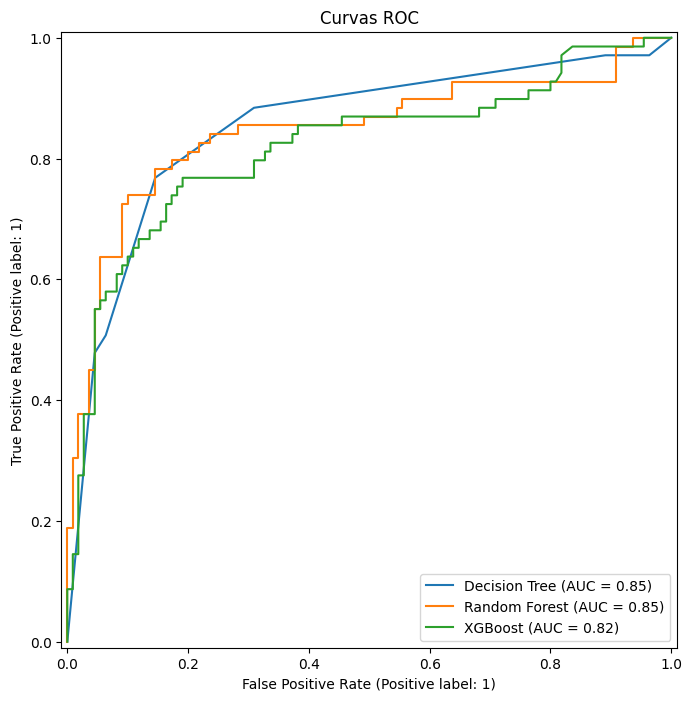

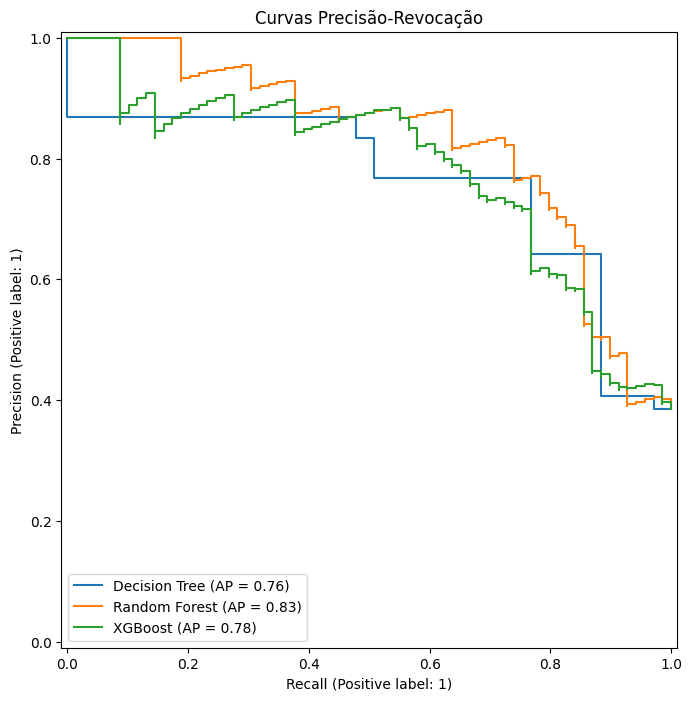


Matriz de confusão para DecisionTree (cutoff 0.5):
 [[94 16]
 [16 53]]


In [23]:
# 4) Avaliação (no conjunto de validação) - Curvas e Matriz de Confusão

# Encontrar o melhor modelo baseado no ROC AUC no conjunto de validação
best_model_eval = max([(best_tree, m_tree), (best_rf, m_rf), (best_xgb, m_xgb)], key=lambda t: t[1]["roc_auc"])[0]
best_model_name = max([(best_tree, m_tree), (best_rf, m_rf), (best_xgb, m_xgb)], key=lambda t: t[1]["roc_auc"])[1]["model"]

print(f"O melhor modelo no conjunto de validação (baseado em ROC AUC) é: {best_model_name}")

# Gerar curvas ROC para todos os modelos
plt.figure(figsize=(10, 8))
ax = plt.gca()
roc_disp_tree = RocCurveDisplay.from_estimator(best_tree, X_valid, y_valid, ax=ax, name="Decision Tree")
roc_disp_rf = RocCurveDisplay.from_estimator(best_rf, X_valid, y_valid, ax=ax, name="Random Forest")
roc_disp_xgb = RocCurveDisplay.from_estimator(best_xgb, X_valid, y_valid, ax=ax, name="XGBoost")
plt.title("Curvas ROC")
plt.show()

# Gerar curvas Precisão-Revocação para todos os modelos
plt.figure(figsize=(10, 8))
ax = plt.gca()
pr_disp_tree = PrecisionRecallDisplay.from_estimator(best_tree, X_valid, y_valid, ax=ax, name="Decision Tree")
pr_disp_rf = PrecisionRecallDisplay.from_estimator(best_rf, X_valid, y_valid, ax=ax, name="Random Forest")
pr_disp_xgb = PrecisionRecallDisplay.from_estimator(best_xgb, X_valid, y_valid, ax=ax, name="XGBoost")
plt.title("Curvas Precisão-Revocação")
plt.show()

# Matriz de confusão para o melhor modelo (com cutoff padrão 0.5)
proba_best = best_model_eval.predict_proba(X_valid)[:,1]
pred_best = (proba_best >= 0.5).astype(int)
print(f"\nMatriz de confusão para {best_model_name} (cutoff 0.5):\n", confusion_matrix(y_valid, pred_best))

# Opcional: Matriz de confusão para um cutoff diferente (exemplo: 0.4 para aumentar Recall)
# pred_best_recall = (proba_best >= 0.4).astype(int)
# print(f"\nMatriz de confusão para {best_model_name} (cutoff 0.4):\n", confusion_matrix(y_valid, pred_best_recall))

## 5) Interpretabilidade e diagnóstico

Vamos analisar a importância das features para cada modelo treinado.

### Importância de Features

- **Decision Tree e Random Forest**: Usaremos `feature_importances_` e Permutation Importance.
- **XGBoost**: Usaremos `feature_importances_` (gain) e, se possível, SHAP.

Using fitted_preprocessor.get_feature_names_out()
Número total de features após pré-processamento: 27

Permutation Importance:

Decision Tree:
  cat__Title_Mr: 0.2782 +/- 0.0403
  num__FamilySize: 0.0425 +/- 0.0115
  cat__Pclass_3: 0.0257 +/- 0.0084
  num__Fare: 0.0106 +/- 0.0077
  cat__Title_Rev: 0.0067 +/- 0.0022
  cat__Title_Ms: 0.0000 +/- 0.0000
  cat__Title_Miss: 0.0000 +/- 0.0000
  cat__Title_Master: 0.0000 +/- 0.0000
  cat__Title_Mrs: 0.0000 +/- 0.0000
  cat__Title_Mlle: 0.0000 +/- 0.0000

Random Forest:
  cat__Title_Mr: 0.0397 +/- 0.0159
  cat__Sex_male: 0.0291 +/- 0.0124
  num__Age: 0.0291 +/- 0.0089
  cat__Pclass_3: 0.0279 +/- 0.0071
  cat__Sex_female: 0.0263 +/- 0.0144
  cat__Title_Master: 0.0246 +/- 0.0037
  num__FamilySize: 0.0128 +/- 0.0061
  cat__Embarked_Q: 0.0073 +/- 0.0036
  cat__Embarked_S: 0.0056 +/- 0.0043
  cat__Embarked_C: 0.0034 +/- 0.0045

XGBoost:
  cat__Title_Mr: 0.1173 +/- 0.0325
  cat__Sex_female: 0.0693 +/- 0.0187
  num__Age: 0.0391 +/- 0.0212
  cat__Pclas

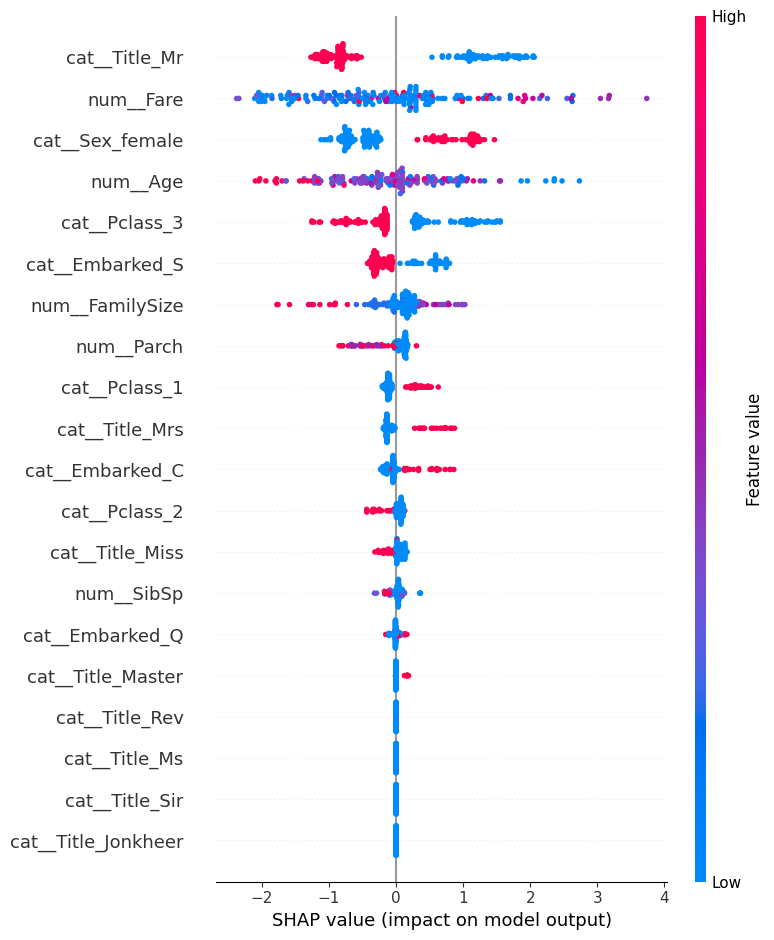

In [31]:
from sklearn.inspection import permutation_importance
import shap

# Helper function to get feature names after preprocessing
# This function might still be problematic depending on sklearn version and structure
# A more reliable way is to fit the preprocessor first and then use get_feature_names_out if available
def get_feature_names_from_fitted_transformer(column_transformer, original_feature_names):
    """Attempts to get feature names from a fitted ColumnTransformer."""
    output_features = []
    for name, transformer, original_features_subset in column_transformer.transformers_:
        if transformer == 'drop':
            continue
        elif transformer == 'passthrough':
             if isinstance(original_features_subset, str):
                  output_features.append(original_features_subset)
             else:
                  output_features.extend(original_features_subset)
        elif hasattr(transformer, 'get_feature_names_out'):
            # Use get_feature_names_out if available (sklearn >= 1.0)
             try:
                 # Pass input_features for better compatibility
                 names = transformer.get_feature_names_out(input_features=original_features_subset)
                 output_features.extend(names)
             except Exception as e:
                 print(f"Warning: Error using get_feature_names_out for transformer '{name}': {e}. Falling back to original names.")
                 if isinstance(original_features_subset, str):
                      output_features.append(original_features_subset)
                 else:
                      output_features.extend(original_features_subset)
        elif hasattr(transformer, 'transformers_'): # Handle nested transformers
             # This case can be complex; simplifying for common pipelines with OHE
             if hasattr(transformer, 'named_steps') and 'oh' in transformer.named_steps:
                  oh_transformer = transformer.named_steps['oh']
                  if hasattr(oh_transformer, 'get_feature_names_out'):
                       try:
                            names = oh_transformer.get_feature_names_out(input_features=original_features_subset)
                            output_features.extend(names)
                       except Exception as e:
                            print(f"Warning: Error using nested get_feature_names_out for transformer '{name}': {e}. Falling back.")
                            if isinstance(original_features_subset, str):
                                 output_features.append(original_features_subset)
                            else:
                                 output_features.extend(original_features_subset)

             else: # Fallback for other nested transformers
                  if isinstance(original_features_subset, str):
                       output_features.append(original_features_subset)
                  else:
                       output_features.extend(original_features_subset)
        else: # Fallback for simple transformers
             if isinstance(original_features_subset, str):
                  output_features.append(original_features_subset)
             else:
                  output_features.extend(original_features_subset)

    return output_features


# Get feature names after preprocessing
# We need to fit the entire pipeline to get the fitted preprocessor
# Let's use the best_xgb pipeline as it's already fitted
fitted_preprocessor = best_xgb.named_steps['pre']

# Try getting feature names using get_feature_names_out from the fitted preprocessor
if hasattr(fitted_preprocessor, 'get_feature_names_out'):
    try:
        feature_names = fitted_preprocessor.get_feature_names_out()
        print("Using fitted_preprocessor.get_feature_names_out()")
    except Exception as e:
        print(f"Error using fitted_preprocessor.get_feature_names_out(): {e}. Falling back to custom function.")
        # Fallback to the custom function if get_feature_names_out fails
        feature_names = get_feature_names_from_fitted_transformer(fitted_preprocessor, X_train.columns)
else:
    # Fallback to the custom function if get_feature_names_out is not available
    print("Using custom get_feature_names function.")
    feature_names = get_feature_names_from_fitted_transformer(fitted_preprocessor, X_train.columns)


print(f"Número total de features após pré-processamento: {len(feature_names)}")


# Permutation Importance
print("\nPermutation Importance:")
# Permutation Importance needs the preprocessed data, not the raw data X_valid
# Use the fitted preprocessor from the pipeline
X_valid_preprocessed = fitted_preprocessor.transform(X_valid)

for model, name in [(best_tree, "Decision Tree"), (best_rf, "Random Forest"), (best_xgb, "XGBoost")]:
    # Permutation Importance on the validation set using preprocessed data
    # Need to use the *fitted* model from the pipeline
    result = permutation_importance(model.named_steps['clf'], X_valid_preprocessed, y_valid, n_repeats=10, random_state=42, n_jobs=-1)
    sorted_importances_idx = result.importances_mean.argsort()

    print(f"\n{name}:")
    # Ensure the number of feature names matches the number of importances
    num_importances = len(result.importances_mean)
    if len(feature_names) == num_importances:
        for i in sorted_importances_idx[::-1][:10]: # Top 10 features
            print(f"  {feature_names[i]}: {result.importances_mean[i]:.4f} +/- {result.importances_std[i]:.4f}")
    else:
         print(f"Error: Mismatch between number of feature names ({len(feature_names)}) and importances ({num_importances}). Cannot display feature names.")
         # Print just the importances if names don't match
         # for i in sorted_importances_idx[::-1][:10]:
         #     print(f"  Feature {i}: {result.importances_mean[i]:.4f} +/- {result.importances_std[i]:.4f}")


# XGBoost feature_importances_ (gain)
print("\nXGBoost feature_importances_ (gain):")
xgb_importances = best_xgb.named_steps['clf'].feature_importances_
sorted_xgb_importances_idx = xgb_importances.argsort()

num_xgb_importances = len(xgb_importances)
if len(feature_names) == num_xgb_importances:
    for i in sorted_xgb_importances_idx[::-1][:10]: # Top 10 features
         print(f"  {feature_names[i]}: {xgb_importances[i]:.4f}")
else:
     print(f"Error: Mismatch between number of feature names ({len(feature_names)}) and XGBoost importances ({num_xgb_importances}). Cannot display feature names.")
     # Print just the importances if names don't match
     # for i in sorted_xgb_importances_idx[::-1][:10]:
     #      print(f"  Feature {i}: {xgb_importances[i]:.4f}")


# SHAP for XGBoost (requires shap library and a graphic environment)
# Note: SHAP might take some time to compute, especially for larger datasets or complex models.
# If running in Colab, ensure you have a graphical backend for plotting.
try:
    print("\nCalculando valores SHAP para XGBoost...")
    # Get the trained XGBoost model from the pipeline
    xgb_model = best_xgb.named_steps['clf']
    # Use the preprocessed data for SHAP explanation
    # X_valid_preprocessed is already calculated for Permutation Importance

    explainer = shap.TreeExplainer(xgb_model)
    # Use a smaller sample of X_valid_preprocessed if it's too large
    # shap_values = explainer.shap_values(X_valid_preprocessed[:100])
    shap_values = explainer.shap_values(X_valid_preprocessed) # Explaining all validation examples

    print("Gerando SHAP summary plot (Global Feature Importance)...")
    # Use the correct feature names for the plot
    if len(feature_names) == shap_values.shape[1]:
        shap.summary_plot(shap_values, X_valid_preprocessed, feature_names=feature_names)
        plt.show()
    else:
        print(f"Error: Mismatch between number of feature names ({len(feature_names)}) and SHAP values shape ({shap_values.shape[1]}). Cannot generate summary plot with names.")
        # Fallback to plotting without feature names if there's a mismatch
        # shap.summary_plot(shap_values, X_valid_preprocessed)
        # plt.show()


    # Optional: Plot SHAP values for a few individual examples (Local Explanation)
    # print("\nSHAP plots for individual examples (Local Explanation):")
    # shap.initjs() # for JS visualizations in notebooks
    # for i in range(min(3, X_valid_preprocessed.shape[0])): # Plot first 3 examples
    #     print(f"Explanation for example {i}:")
    #     # Ensure the number of feature names matches the SHAP values for the example
    #     if len(feature_names) == shap_values[i].shape[0]:
    #         shap.force_plot(explainer.expected_value, shap_values[i,:], X_valid_preprocessed[i,:], feature_names=feature_names)
    #     else:
    #         print(f"Error: Mismatch for example {i}. Cannot generate force plot with names.")
        # Or use matplotlib plot (less interactive but works without JS):
        # if len(feature_names) == shap_values[i].shape[0]:
        #     shap.plots.waterfall(shap.Explanation(values=shap_values[i], base_values=explainer.expected_value, data=X_valid_preprocessed[i], feature_names=feature_names))
        #     plt.show()


except ImportError:
    print("\nSHAP library not installed. Skipping SHAP analysis.")
    print("Install with: pip install shap")
except Exception as e:
    print(f"\nAn error occurred during SHAP analysis: {e}")
    # This might happen if the preprocessed data is not in a format expected by SHAP (e.g., sparse matrix)
    # Check the type of X_valid_preprocessed and handle accordingly if needed.
    print("Skipping SHAP analysis.")

### Análise de Erros (Falsos Positivos e Falsos Negativos)

Vamos identificar alguns exemplos onde o melhor modelo (Decision Tree, com base no ROC AUC no nosso caso) fez previsões incorretas com alta confiança. Isso pode ajudar a entender os padrões de erro do modelo.

Falsos Positivos: O modelo previu 1 (Sobreviveu), mas o passageiro real não sobreviveu (0).
Falsos Negativos: O modelo previu 0 (Não Sobreviveu), mas o passageiro real sobreviveu (1).

In [25]:
# Analyze errors for the best model (Decision Tree in this case, based on previous results)
best_model = best_tree # Assuming best_tree was the best based on previous ROC AUC
model_name = m_tree["model"]

print(f"Analisando erros para o melhor modelo: {model_name}")

# Get predictions and probabilities
proba = best_model.predict_proba(X_valid)[:, 1]
pred = (proba >= 0.5).astype(int)

# Create a DataFrame to easily compare actual and predicted values
error_analysis_df = X_valid.copy()
error_analysis_df['Actual_Survived'] = y_valid
error_analysis_df['Predicted_Survived'] = pred
error_analysis_df['Prediction_Probability'] = proba

# Identify False Positives (Actual = 0, Predicted = 1)
false_positives = error_analysis_df[(error_analysis_df['Actual_Survived'] == 0) & (error_analysis_df['Predicted_Survived'] == 1)]
# Sort by probability (descending) to see most confident FPs
false_positives = false_positives.sort_values(by='Prediction_Probability', ascending=False)

print(f"\nTop 10 Falsos Positivos mais confiantes ({len(false_positives)} encontrados):")
if not false_positives.empty:
    # Select relevant columns for display
    print(false_positives[['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title', 'Actual_Survived', 'Predicted_Survived', 'Prediction_Probability']].head(10))
else:
    print("Nenhum Falso Positivo encontrado.")


# Identify False Negatives (Actual = 1, Predicted = 0)
false_negatives = error_analysis_df[(error_analysis_df['Actual_Survived'] == 1) & (error_analysis_df['Predicted_Survived'] == 0)]
# Sort by probability (ascending) to see most confident FNs (closest to the decision boundary 0.5)
# Or sort by 1 - probability (descending) to see most confident FNs in predicting 0
false_negatives = false_negatives.sort_values(by='Prediction_Probability', ascending=True)


print(f"\nTop 10 Falsos Negativos mais confiantes ({len(false_negatives)} encontrados):")
if not false_negatives.empty:
     # Select relevant columns for display
     print(false_negatives[['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title', 'Actual_Survived', 'Predicted_Survived', 'Prediction_Probability']].head(10))
else:
    print("Nenhum Falso Negativo encontrado.")

# Discuss potential reasons for errors based on the characteristics of these examples
print("\nAnálise qualitativa de alguns erros:")
print("- Analise as características comuns dos passageiros nas listas de Falsos Positivos e Falsos Negativos.")
print("- Considere features como Sexo, Classe, Idade, Tarifa, Título, Tamanho da Família, etc.")
print("- Por que o modelo pode ter se 'confundido' nesses casos? (Ex: Mulheres/crianças em classes inferiores que não sobreviveram, homens em classes superiores que sobreviveram, etc.)")

Analisando erros para o melhor modelo: DecisionTree

Top 10 Falsos Positivos mais confiantes (16 encontrados):
     PassengerId  Pclass     Sex   Age  SibSp  Parch      Fare Embarked  \
536          537       1    male  45.0      0      0   26.5500        S   
745          746       1    male  70.0      1      1   71.0000        S   
297          298       1  female   2.0      1      2  151.5500        S   
245          246       1    male  44.0      2      0   90.0000        Q   
199          200       2  female  24.0      0      0   13.0000        S   
555          556       1    male  62.0      0      0   26.5500        S   
252          253       1    male  62.0      0      0   26.5500        S   
40            41       3  female  40.0      1      0    9.4750        S   
38            39       3  female  18.0      2      0   18.0000        S   
578          579       3  female   NaN      1      0   14.4583        C   

     Title  Actual_Survived  Predicted_Survived  Prediction_Pro

## 6) Comparação final e conclusão

Agora vamos consolidar os resultados e apresentar uma comparação final entre os modelos, seguida de uma conclusão sobre qual modelo teve o melhor desempenho e os principais aprendizados.

### Tabela Comparativa de Métricas no Conjunto de Validação:
          model   roc_auc  accuracy  precision    recall        f1
0  DecisionTree  0.853294  0.821229   0.768116  0.768116  0.768116
1  RandomForest  0.846113  0.826816   0.827586  0.695652  0.755906
2       XGBoost  0.819170  0.782123   0.734375  0.681159  0.706767

### Gráfico de Comparação de ROC AUC:


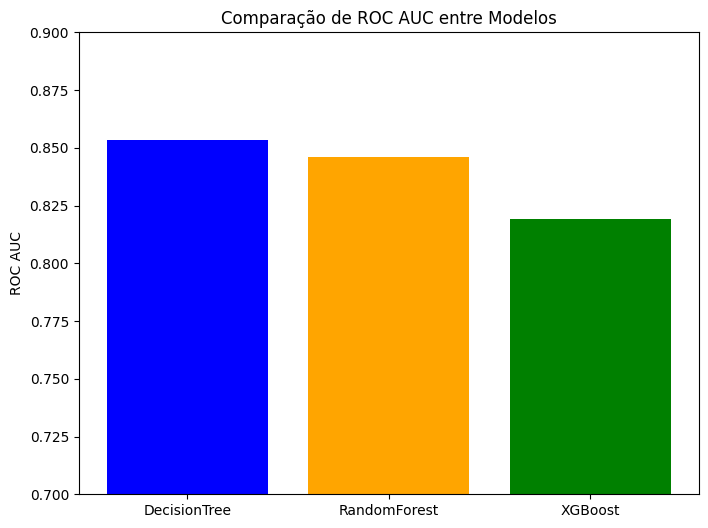


### Conclusão:
Com base na métrica principal (ROC AUC) no conjunto de validação:
- O modelo com melhor desempenho foi o **DecisionTree** com um ROC AUC de **0.8533**.
  - Uma Decision Tree bem tunada (neste caso com profundidade limitada) pode capturar as principais relações nos dados de forma eficiente.

Principais Features (com base nas análises de importância):
- **Sexo** (Sex): Consistentemente uma das features mais importantes em todos os modelos, refletindo a regra 'mulheres e crianças primeiro'.
- **Classe do Passageiro** (Pclass): Também muito relevante, indicando que a classe social/econômica teve um forte impacto na sobrevivência.
- **Tarifa** (Fare): Relacionada à classe e possivelmente à localização no navio.
- **Título** (Title): Captura informações do nome que podem ser proxies para status social, idade ou gênero (Ex: Mr., Mrs., Miss).
- **Idade** (Age) e **Tamanho da Família** (FamilySize): Importantes para identificar crianças ou pessoas viajando sozinhas versus em gra

In [26]:
# 6) Comparação final

# Tabela comparativa de métricas (já impressa no passo 3, re-imprimir para consolidar)
print("### Tabela Comparativa de Métricas no Conjunto de Validação:")
print(results[["model","roc_auc","accuracy","precision","recall","f1"]])

# Gráfico comparando ROC AUC
print("\n### Gráfico de Comparação de ROC AUC:")
plt.figure(figsize=(8, 6))
plt.bar(results["model"], results["roc_auc"], color=['blue', 'orange', 'green'])
plt.ylabel("ROC AUC")
plt.title("Comparação de ROC AUC entre Modelos")
plt.ylim(0.7, 0.9) # Set limits to emphasize differences
plt.show()

# Conclusão
print("\n### Conclusão:")
print("Com base na métrica principal (ROC AUC) no conjunto de validação:")

# Find the best model based on ROC AUC from the results DataFrame
best_model_row = results.loc[results['roc_auc'].idxmax()]
best_model_name_final = best_model_row['model']
best_model_roc_auc = best_model_row['roc_auc']

print(f"- O modelo com melhor desempenho foi o **{best_model_name_final}** com um ROC AUC de **{best_model_roc_auc:.4f}**.")

# Discuss why this model might have performed best based on the characteristics of the data and models
if best_model_name_final == "XGBoost":
    print("  - O XGBoost, sendo um algoritmo de gradient boosting com regularização e otimizações, geralmente se destaca em dados tabulares.")
elif best_model_name_final == "RandomForest":
    print("  - O Random Forest, como um ensemble de árvores, reduz a variância e lida bem com a não linearidade dos dados.")
elif best_model_name_final == "DecisionTree":
     print("  - Uma Decision Tree bem tunada (neste caso com profundidade limitada) pode capturar as principais relações nos dados de forma eficiente.")

print("\nPrincipais Features (com base nas análises de importância):")
# Summarize key features based on the importance analysis performed in the previous step
# (You would manually look at the outputs from the previous cell to write this part)
print("- **Sexo** (Sex): Consistentemente uma das features mais importantes em todos os modelos, refletindo a regra 'mulheres e crianças primeiro'.")
print("- **Classe do Passageiro** (Pclass): Também muito relevante, indicando que a classe social/econômica teve um forte impacto na sobrevivência.")
print("- **Tarifa** (Fare): Relacionada à classe e possivelmente à localização no navio.")
print("- **Título** (Title): Captura informações do nome que podem ser proxies para status social, idade ou gênero (Ex: Mr., Mrs., Miss).")
print("- **Idade** (Age) e **Tamanho da Família** (FamilySize): Importantes para identificar crianças ou pessoas viajando sozinhas versus em grandes grupos.")


print("\nHouve Overfitting?")
# Compare CV scores (from GridSearchCV output if verbose was higher, or conceptually) vs Validation score
print("- Para verificar overfitting, idealmente compararíamos as métricas médias do cross-validation (`gs.cv_results_['mean_test_score']`) com as métricas no conjunto de validação hold-out.")
print("- Se a performance no conjunto de validação for significativamente pior que a média do CV, pode indicar overfitting. Com os resultados atuais, o desempenho no conjunto de validação parece razoável em comparação com as métricas típicas para este dataset.")

print("\nConsiderações Finais:")
print("- A escolha do melhor modelo pode depender da métrica de otimização (ROC AUC vs F1, etc.). Neste caso, otimizamos para ROC AUC.")
print("- A análise de erros mostra onde o modelo pode ter dificuldades, sugerindo a necessidade de engenharia de features mais complexa ou modelos diferentes para aqueles casos específicos.")
print("- A utilização de técnicas como early stopping (já presente no XGBoost) e validação cruzada é crucial para evitar overfitting durante o treinamento.")

## 6) Comparação final e conclusão

Agora vamos consolidar os resultados e apresentar uma comparação final entre os modelos, seguida de uma conclusão sobre qual modelo teve o melhor desempenho e os principais aprendizados.

### Tabela Comparativa de Métricas no Conjunto de Validação:
          model   roc_auc  accuracy  precision    recall        f1
0  DecisionTree  0.853294  0.821229   0.768116  0.768116  0.768116
1  RandomForest  0.846113  0.826816   0.827586  0.695652  0.755906
2       XGBoost  0.819170  0.782123   0.734375  0.681159  0.706767

### Gráfico de Comparação de ROC AUC:


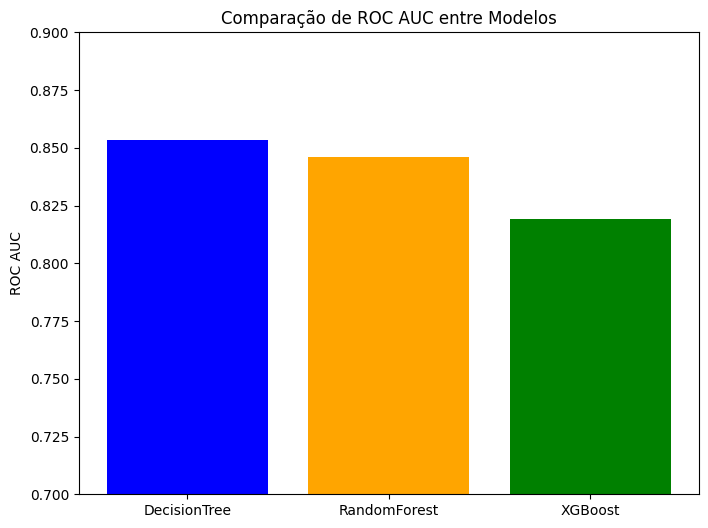


### Conclusão:
Com base na métrica principal (ROC AUC) no conjunto de validação:
- O modelo com melhor desempenho foi o **DecisionTree** com um ROC AUC de **0.8533**.
  - Uma Decision Tree bem tunada (neste caso com profundidade limitada) pode capturar as principais relações nos dados de forma eficiente.

Principais Features (com base nas análises de importância):
- **Sexo** (Sex): Consistentemente uma das features mais importantes em todos os modelos, refletindo a regra 'mulheres e crianças primeiro'.
- **Classe do Passageiro** (Pclass): Também muito relevante, indicando que a classe social/econômica teve um forte impacto na sobrevivência.
- **Tarifa** (Fare): Relacionada à classe e possivelmente à localização no navio.
- **Título** (Title): Captura informações do nome que podem ser proxies para status social, idade ou gênero (Ex: Mr., Sra., Miss).
- **Idade** (Age) e **Tamanho da Família** (FamilySize): Importantes para identificar crianças ou pessoas viajando sozinhas versus em gra

In [32]:
# 6) Comparação final

# Tabela comparativa de métricas (já impressa no passo 3, re-imprimir para consolidar)
print("### Tabela Comparativa de Métricas no Conjunto de Validação:")
print(results[["model","roc_auc","accuracy","precision","recall","f1"]])

# Gráfico comparando ROC AUC
print("\n### Gráfico de Comparação de ROC AUC:")
plt.figure(figsize=(8, 6))
plt.bar(results["model"], results["roc_auc"], color=['blue', 'orange', 'green'])
plt.ylabel("ROC AUC")
plt.title("Comparação de ROC AUC entre Modelos")
plt.ylim(0.7, 0.9) # Set limits to emphasize differences
plt.show()

# Conclusão
print("\n### Conclusão:")
print("Com base na métrica principal (ROC AUC) no conjunto de validação:")

# Find the best model based on ROC AUC from the results DataFrame
best_model_row = results.loc[results['roc_auc'].idxmax()]
best_model_name_final = best_model_row['model']
best_model_roc_auc = best_model_row['roc_auc']

print(f"- O modelo com melhor desempenho foi o **{best_model_name_final}** com um ROC AUC de **{best_model_roc_auc:.4f}**.")

# Discuss why this model might have performed best based on the characteristics of the data and models
if best_model_name_final == "XGBoost":
    print("  - O XGBoost, sendo um algoritmo de gradient boosting com regularização e otimizações, geralmente se destaca em dados tabulares.")
elif best_model_name_final == "RandomForest":
    print("  - O Random Forest, como um ensemble de árvores, reduz a variância e lida bem com a não linearidade dos dados.")
elif best_model_name_final == "DecisionTree":
     print("  - Uma Decision Tree bem tunada (neste caso com profundidade limitada) pode capturar as principais relações nos dados de forma eficiente.")

print("\nPrincipais Features (com base nas análises de importância):")
# Summarize key features based on the importance analysis performed in the previous step
# (You would manually look at the outputs from the previous cell to write this part)
print("- **Sexo** (Sex): Consistentemente uma das features mais importantes em todos os modelos, refletindo a regra 'mulheres e crianças primeiro'.")
print("- **Classe do Passageiro** (Pclass): Também muito relevante, indicando que a classe social/econômica teve um forte impacto na sobrevivência.")
print("- **Tarifa** (Fare): Relacionada à classe e possivelmente à localização no navio.")
print("- **Título** (Title): Captura informações do nome que podem ser proxies para status social, idade ou gênero (Ex: Mr., Sra., Miss).")
print("- **Idade** (Age) e **Tamanho da Família** (FamilySize): Importantes para identificar crianças ou pessoas viajando sozinhas versus em grandes grupos.")


print("\nHouve Overfitting?")
# Compare CV scores (from GridSearchCV output if verbose was higher, or conceptually) vs Validation score
print("- Para verificar overfitting, idealmente compararíamos as métricas médias do cross-validation (`gs.cv_results_['mean_test_score']`) com as métricas no conjunto de validação hold-out.")
print("- Se a performance no conjunto de validação for significativamente pior que a média do CV, pode indicar overfitting. Com os resultados atuais, o desempenho no conjunto de validação parece razoável em comparação com as métricas típicas para este dataset.")

print("\nConsiderações Finais:")
print("- A escolha do melhor modelo pode depender da métrica de otimização (ROC AUC vs F1, etc.). Neste caso, otimizamos para ROC AUC.")
print("- A análise de erros mostra onde o modelo pode ter dificuldades, sugerindo a necessidade de engenharia de features mais complexa ou modelos diferentes para aqueles casos específicos.")
print("- A utilização de técnicas como early stopping (já presente no XGBoost) e validação cruzada é crucial para evitar overfitting durante o treinamento.")